## <center>Ch 28 LangChain Retrieval核心模块的Embedding Models与Vector stores

&emsp;&emsp;截止课程进展到这里，对于一个基础形态的RAG系统，借助LangChain框架中的`Document loaders`和`Text Splitters`两个模块，我们能够处理来自多种数据格式和来源的原始数据，并且掌握了一些常用的文本切分方法。因此，对于下图所示的流程，我们已经实现的进度如红框中所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171456586.png" width=80%></div>

&emsp;&emsp;如上图所示，目前得到的每一个chunk，其存储形式还是以字符串形式存在，那么去计算Query和每一个chunk之间的相似度的解决办法是先通过Embedding Models将chunk转化成Vector，再通过余弦相似度等计算文本间相似度的算法匹配出与Query关联度最高的Chunks。关于Embedding相关的理论基础，在大模型技术实战课《Ch.17.1 OpenAI Embedding模型 API 使用指南》已经做了详细的介绍，所以我们这里不再重复说明，还未了解过Embedding技术的小伙伴需要先补充基础知识。在本节课程中，我们将结合RAG流程直接进入Embedding的实践部分。

&emsp;&emsp;本文我们将直接围绕Embedding模型的使用和向量数据库的应用两个技术点展开详细的探讨和实践。

&emsp;&emsp;其实将自然语言文本转化成向量，当然，chunks本质上也是一个个文本，最初来源于Word2vec技术，随后发展到Elmo，再到Bert等， 它是一种自然语言处理（NLP）中词表示技术的一种演变过程。从本质上来说，将文本“chunks”（如单词、短语或句子）转换成向量的过程只是一个简单的编码（Encoding）问题。在这个阶段，我们没必要去纠结Embedding模型的底层原理，只需要懂得如何对具体的需求，找到最合适的Embedding 模型，拿来直接用即可。同样的道理适用于向量数据库。虽然大多数向量数据库的基本功能和使用技巧相似，但每个数据库都有其独特的特性和优点。我们需要的具备的能力是根据自己数据的特点，选择最合适的向量数据库。然后再花时间去学习和掌握该数据库的高级应用技巧，一定要避免将时间浪费在不必要的学习上。

&emsp;&emsp;所以本节课程接下来的内容，我们将从应用的角度出发，结合LangChian框架带大家实操不同类型的Embedding Models 和 Vector Stores中一些较为通用的使用方法，并从宏观的角度向大家介绍应该如何选择最适合的Embedding Models或者Vector Stores，而更进阶的用法和深度的应用技巧，我们在本系列课程最后的企业级应用案例中，会选择一个或多个比较流行Embedding Models和Vector Stores，结合具体的应用展开进一步的探讨。

&emsp;&emsp;接下来，我们首先进行第一部分内容，向大家介绍在LangChain应用框架下的Embedding Models的接入及使用方法。

# 1. Text Embedding Models

&emsp;&emsp;在langchain的原生数据处理流`Data connection`中，Embedding Models所处的位置如下图红框内所示：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171540661.png" width=80%></div>

&emsp;&emsp;LangChain 设计了一个 Embeddings 类，用来实现与Embedding Models的交互。API地址：https://api.python.langchain.com/en/latest/langchain_api_reference.html#module-langchain.embeddings

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171544029.png" width=80%></div>

&emsp;&emsp;LangChain 中的 Embeddings 基类提供了两种方法：一种用于Embeddin文档对象，另一种用于Embdding查询（Query）。前者采用多个文本作为输入，而后者采用单个文本。

&emsp;&emsp;而我们前面说Embedding Models只需要学会如何去使用就可以，是因为有非常多的托管平台，如OpenAI、Hugging Face 等都提供了标准接口并集成在LangChian框架中，这意味着：Embedding Models已经有人帮我们训练好了，我们只要按照其提供的接口规范，将自然语言文本传入进去，就能得到其对应的向量表示。这显然是非常简单的。

&emsp;&emsp;那么在如此多的Embedding Models都可以使用的情况下，应该如何选择呢？ 首先，我们在使用形式上把 Embedding Models分为两类：

1. 在线Embedding Models：以OpenAI的`text-embedding-3`为代表，仅提供API服务，需要按照Token付费；
2. 开源EMbedding Models：以`bge-base-zh-v1.5`为代表，这类模型托管在Hugging Face或ModelScope平台上，可以下载到本地免费使用，但在运行过程中会消耗GPU资源。

&emsp;&emsp;除此以外，从Embedding效果上划分，我们可以简单直接的划分为：OpenAI Embedding Models与 其他Embedding Model两类。这也是因为在大量的实践中，OpenAI的`text-embedding-3`模型生成的向量几乎在全任务上都能取得更好的效果，尽管在一些榜单中有其他的Embedding Models的评测位于OpenAI Embedding Model之前，而出现这种情况，相信大家也是"懂的"。

&emsp;&emsp;接下来，我们也将围绕这两类不同类型的Embedding Models，逐一向大家介绍其在LangChain中的应用方法。首先来看OpenAI Embedding Models的使用。

## 1.1 OpenAI Embeddings Model

&emsp;&emsp;OpenAI的Embedding Model目前有三个，均只提供API形式的调用服务，可以在OpenAI官网查看相关的细节：https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151801672.png" width=80%></div>

&emsp;&emsp;不同的Embedding Models收费标准也不同，但都是以Token数为计量单位，相关资费说明如下所示：https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171606065.png

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171606065.png" width=80%></div>

&emsp;&emsp;调用方法非常简单，如下代码所示：

In [42]:
from openai import OpenAI
client = OpenAI()

small_response = client.embeddings.create(
    input="你好",
    model="text-embedding-3-small"
)

&emsp;&emsp;默认情况下，对于`text-embeddings-3-small`，Embedding向量的长度为1536，而`text-embeddings-3-large`生成的向量长度则为3072。

In [43]:
len(small_response.data[0].embedding)

1536

In [44]:
large_response = client.embeddings.create(
    input="你好",
    model="text-embedding-3-large"
)

In [45]:
len(large_response.data[0].embedding)

3072

&emsp;&emsp;当然，也可以通过传入`dimensions`参数来灵活的调整Embedding的维度，且OpenAI的官方说明，这样的调整并不会影响其生成的词表示的效果。比如：

In [47]:
dim_response = client.embeddings.create(
    input="你好",
    model="text-embedding-3-large",
    dimensions=1024
)

In [48]:
len(dim_response.data[0].embedding)

1024

In [49]:
dim_response.data[0].embedding

[-0.08211681246757507,
 0.016409981995821,
 0.013399414718151093,
 0.026225388050079346,
 0.02343463897705078,
 -0.027391385287046432,
 -0.0027955269906669855,
 0.07252122461795807,
 0.00938054546713829,
 0.046181149780750275,
 -0.05264192074537277,
 0.01852215826511383,
 -0.006656699348241091,
 0.035591598600149155,
 -0.03044973872601986,
 0.045722395181655884,
 0.028882332146167755,
 -0.007010321132838726,
 0.007244476582854986,
 -0.024371260777115822,
 0.011688647791743279,
 -0.03507550060749054,
 0.03150104731321335,
 0.04813085123896599,
 0.0026497773360460997,
 0.02043362893164158,
 -0.0006206308607943356,
 0.019372763112187386,
 -0.030220363289117813,
 -0.07967013120651245,
 0.012395892292261124,
 0.02333906665444374,
 -0.008768875151872635,
 0.004334261175245047,
 0.04499603807926178,
 0.005887331906706095,
 0.04270227253437042,
 -0.005208759568631649,
 -0.0015518758445978165,
 0.05474454164505005,
 -0.0011462854454293847,
 0.038420576602220535,
 -0.012845087796449661,
 0.04434

&emsp;&emsp;整体上看其使用方法还是非常简单的，也并没有什么额外的操作技巧，那么在LangChain框架中，使用OpenAI的Embedding，则需要借助到其已经封装好的`OpenAIEmbeddings`类。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151823944.png" width=80%></div>

&emsp;&emsp;其源码如下图所示：

```python
class OpenAIEmbeddings(BaseModel, Embeddings):
    """OpenAI embedding models.

    To use, you should have the ``openai`` python package installed, and the
    environment variable ``OPENAI_API_KEY`` set with your API key or pass it
    as a named parameter to the constructor.

    Example:
        .. code-block:: python

            from langchain_community.embeddings import OpenAIEmbeddings
            openai = OpenAIEmbeddings(openai_api_key="my-api-key")
    """
    
     def embed_documents(
        self, texts: List[str], chunk_size: Optional[int] = 0
    ) -> List[List[float]]:
        """Call out to OpenAI's embedding endpoint for embedding search docs.

        Args:
            texts: The list of texts to embed.
            chunk_size: The chunk size of embeddings. If None, will use the chunk size
                specified by the class.

        Returns:
            List of embeddings, one for each text.
        """
        # NOTE: to keep things simple, we assume the list may contain texts longer
        #       than the maximum context and use length-safe embedding function.
        engine = cast(str, self.deployment)
        return self._get_len_safe_embeddings(texts, engine=engine)
    
    
    def embed_query(self, text: str) -> List[float]:
        """Call out to OpenAI's embedding endpoint for embedding query text.

        Args:
            text: The text to embed.

        Returns:
            Embedding for the text.
        """
        return self.embed_documents([text])[0]

```

&emsp;&emsp; `OpenAIEmbeddings` 继承自 `BaseModel` 和 `Embeddings`，实现的就是利用 OpenAI 的Embedding模型获取文本的Embedding向量。只包含两个函数：

1. `embed_documents`：将给定的文本列表转换成Embedding向量。它接受两个参数：

    - `texts`: 需要转换成Embedding向量的文本列表。
    - `chunk_size`: 指定每次处理的文本块的大小。如果为0或None，那么将使用类中指定的默认大小，默认为0
    <br><br>
2. `embed_query`：用于获取单个文本的Embedding向量。它是 `embed_documents` 函数的一个特例，专门用于处理单一文本输入。

    - `text`: 需要转化为Vector的单个文本。
    - 函数内部通过调用 `embed_documents` 函数实现，将单个文本放入列表中，调用该函数后，取结果列表的第一个元素作为输出。

&emsp;&emsp;理解了上述源码后，`OpenAIEmbeddings`类的使用方法就非常明确了，这里我们进行一下尝试。首先，如果没有安装`langchain-openai`的话，需要进行安装。

In [3]:
# ! pip install -qU langchain-openai

&emsp;&emsp;导入`OpenAIEmbeddings`方法。

In [52]:
from langchain_openai import OpenAIEmbeddings

&emsp;&emsp;通过源码可以看到，一种是对Document 进行Embedding，一种是对Query进行Embedding，区别就在于类的使用方法上，对于文档的Embedding，可以输入很多内容，可以有多条，对于query，通常是单个文本，这个与使用场景还是非常相像的。如果要使用`OpenAIEmbeddings`类调用OpenAI的Embedding Model对文本生成Vector，首先还是要进行实例化，代码如下：

In [53]:
# 默认使用的模型是：text-embedding-ada-002

embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

&emsp;&emsp;使用`embed_documents`方法，可以生成文档对象的Embedding，其接收的类型为一个列表。

In [55]:
embeddings = embeddings_model.embed_documents(
    [
        "你好",
        "今天的天气好吗",
        "我是木羽",
        "如果你需要找我，请给我打电话吧",
        "明天我们一起去郊游"
    ]
)

&emsp;&emsp;这里每一条文本，都会生成一个单独的Embedding Vector。

In [56]:
len(embeddings)

5

&emsp;&emsp;每个单独的Embedding Vector的维度都是1536，这是由Embedding Models决定的。

In [57]:
len(embeddings[0])

1536

&emsp;&emsp;接下来生成`query`对应的Embedding Vector，这需要使用的方法是`embed_query`，其接受单条字符串形式的文本，代码如下：

In [58]:
# QA场景：嵌入一段文本，以便与其他嵌入进行比较。
embedded_query = embeddings_model.embed_query("你好，请问你叫什么？")

&emsp;&emsp;同样，使用相同的Embedding 模型实例，返回的Embedding 维度也是 1536。

In [36]:
len(embedded_query)

1536

&emsp;&emsp;接下来我们通过一个稍加复杂的流程，测试一下关于Embedding 生成的向量，不同语义的文本之间的关系是怎样的，从而验证通过Embedding Models得到的Vector是否具有较强的语义信息。理论上，如果Embedding Vector足够好，那么自然语义相近的原始的文本会更相似。

In [61]:
from langchain_openai import OpenAIEmbeddings

&emsp;&emsp;这里模拟一个QA场景，我们定义一个问题，然后定义10条文本作为回答，其中仅有两条文本（即第一条和第二条）与提出的Query有较强的相关性。

In [77]:
query = "早睡早起到底是不是保持身体健康的标准？"

sentences = ["早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。", 
             "早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。",
             "关于提高工作效率，确保在日常饮食中包含充足的蛋白质、复合碳水化合物和健康脂肪非常关键。",
             "投资可再生能源项目和推广电动汽车可以显著减少温室气体排放，从而缓解气候变化带来的负面影响。",
             "多发性硬化症是一种影响中枢神经系统的自身免疫疾病，导致神经传导受损。虽然与阿尔茨海默症类似，多发性硬化症的主要症状包括疲劳、视觉障碍和肌肉控制问题。",
             "今天的天气太好了，可以早点起床去爬山",
             "如果下班特别晚的话，我建议你还是打车回家吧",
             "提升学术研究质量需侧重于多学科融合和国际合作。研究机构应该鼓励学者之间的交流，通过共享数据和研究方法，来推动科学发现和技术创新。",
             "如果你认为我说的没用，那你大可以不必理会。",
             "衡量一个人是否成功的标准在于他到底能不能让身边的人都变的优秀"

]

&emsp;&emsp;实例化Embedding 模型。

In [78]:
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

&emsp;&emsp;使用`embed_documents`方法，传入`sentences`列表，得到每条文本的向量表示。

In [79]:
sentence_embeddings = embeddings_model.embed_documents(sentences)

In [80]:
len(sentence_embeddings)

10

In [81]:
len(sentence_embeddings[0])

1536

&emsp;&emsp;通过`embed_query`方法生成问题的向量表示。

In [82]:
# QA场景：嵌入一段文本，以便与其他Embedding Vector进行比较。
embedded_query = embeddings_model.embed_query(query)

In [83]:
len(embedded_query)

1536

&emsp;&emsp;然后，我们通过t-SNE降维算来可视化Embedding向量在二维空间中的分布。代码如下所示：

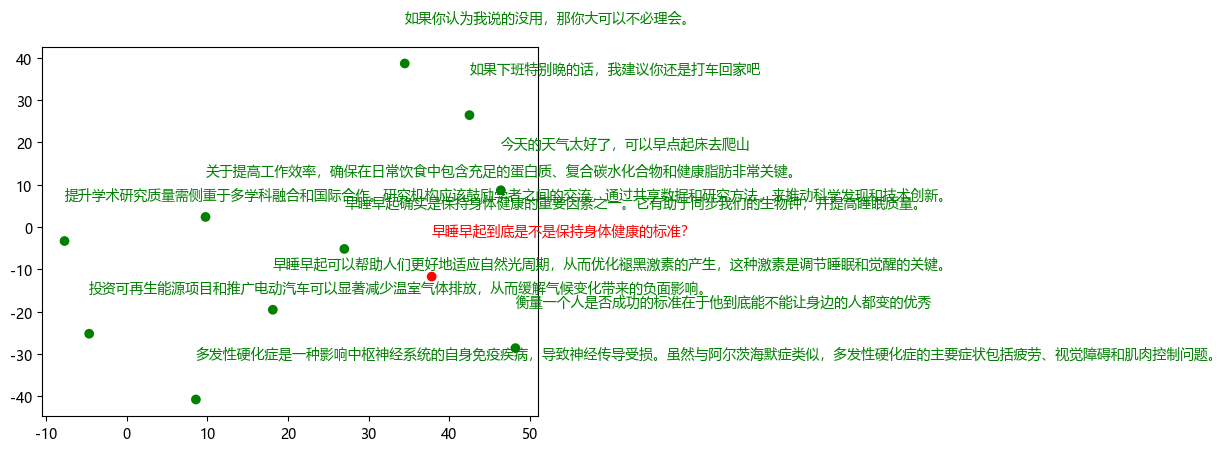

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 设置字体以支持中文显示
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 将查询句子的嵌入添加到句子嵌入数组的首位
all_embeddings = np.vstack([embedded_query, sentence_embeddings])

# 运行 TSNE 降维，固定随机种子以保持结果一致
# n_components (整数): 这个参数指定目标空间的维度。在这里设置为 2，意味着t-SNE将把数据降维到二维空间。
# perplexity (浮点数): 这个参数是t-SNE中非常重要的一个参数，可以看作是考虑周围邻居的数量，它反映了数据局部结构的复杂性。
tsne = TSNE(n_components=2, perplexity=5)  
embeddings_2d = tsne.fit_transform(all_embeddings)

# 创建颜色列表，查询句子为红色，其余为绿色
color_list = ['red'] + ['green'] * len(sentence_embeddings)

# 绘制散点图
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color_list)

# 添加文本标签，包括查询句子
sentences_with_query = [query] + sentences  # 加入查询句子到句子列表首位
for i in range(len(embeddings_2d)):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1] + 10,  # 小幅调整文本位置以防重叠
             sentences_with_query[i],
             color=color_list[i])

    
# 显示图表
plt.show()

&emsp;&emsp;从上图中能够非常明显的看出，在分布上红色显示的为Query，不同文本间距离的远近表示着文本间的关联度，关联越大，两个文本的显示距离就越近。对`早睡早起到底是不是保持身体健康的标准？`这个问题，在10个绿色字体的答案中，两个最相关的`早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。`和`早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。`是距离最近的，同时从自然语义上，也是最能回答该问题的答案。如果这是一个RAG系统，那么被检索出来的内容就会是这两个问题。从而也印证了Embeding后的向量，是具有极强的语义的。

> 有一点需要说明：大家在自己执行时会出现多次执行结果不同的情况，这是正常的，这是由于 t-SNE  算法的特性导致的。它在初始化过程中有一定的随机性。这意味着每次运行算法时，即使是在相同的Embeding向量上，得到的低维表示也可能不同。

&emsp;&emsp;除了OpenAI的Embedding Models可以使用API形式接入之外，LangChain也接入了其他提供API调用的平台，比如国内的Baidu Qianfan，Baichuan Text Embeddings等，具体支持的平台可以在如下位置进行查看：https://python.langchain.com/docs/integrations/text_embedding/

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171734867.png" width=80%></div>

&emsp;&emsp;当然，不同平台提供的Embedding Models也均需要按照其定制的收费标准付费。如果想免费使用Embedding Models，另外的一种形式则是下载开源的Embedding Models至本地，通过本地服务接入，但这个过程，需要消耗本地服务器的硬件资源，即会占用一定的GPU显存。

&emsp;&emsp;接下来我们就介绍一下：如何在LangChain框架中接入开源的Embedding Models。

## 1.2 开源Embedding Models

&emsp;&emsp;在LangChain框架中如果想使用开源Embedding Models，需要先将具体的Embedding Models的全部权重文件下载至本地后才能进行加载，这与本地化部署开源大模型是一样的，其在调用过程中也会消耗一定的GPU资源，而消耗的多少显存则取决于Embedding Models的参数量。

&emsp;&emsp;LangChain集成的开源Embedding模型托管平台主要有Hugging Face、Ollama等，在使用上与OpenAI Embedding Models等API形式差异也并不大，唯一需要做的前置工作是：需要把离线的Embedding Models从指定的托管平台上下载至本地。我们以`BAAI/bge-base-zh-v1.5`模型为例，向大家介绍下载及使用方法，该Embedding Models为ChatGLM系列默认使用的Embedding模型。

&emsp;&emsp;BAAI/bge-base-zh-v1.5模型托管在Hugging Face平台，其托管地址为：https://huggingface.co/BAAI/bge-base-zh-v1.5

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404172140063.png" width=80%></div>

&emsp;&emsp;相关的使用方式也有一个简单的说明，位置如下：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404172142967.png" width=80%></div>

&emsp;&emsp;使用`sentence-transformers`库是一种更适用于广泛场景的使用方式，它基于 Transformer 架构，专门用于生成句子级别的Embedding向量。不仅仅局限于LangChain框架，所以我们先尝试使用更为通用的方式进行`bge-large-zh-v1.5`模型的使用。

&emsp;&emsp;首先安装`sentence-transformers`库，执行如下代码：

```bash
pip install -U sentence-transformers
```

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151623426.png" width=80%></div>

&emsp;&emsp;加载方式非常简单，只需要运行如下两行代码：

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('BAAI/bge-large-zh-v1.5')

/home/util/anaconda3/envs/langchain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name BAAI/bge-large-zh-v1.5. Creating a new one with MEAN pooling.


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like BAAI/bge-large-zh-v1.5 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

&emsp;&emsp;如果是在本机环境下初次执行这段代码，即初次调用`bge-large-zh-v1.5`,它首先执行的操作是从Hugging Face网站进行`bge-large-zh-v1.5`模型权重的下载，然后再进行加载，而大家也知道，国内网络访问Hugging Face 网站是需要开启科学上网的，所以当在一个不具备网络连通性的环境下执行本段代码时，会发生如下报错：`OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like BAAI/bge-large-zh-v1.5 is not the path to a directory containing a file named config.json.`这说明当前服务器上无法链接外网，我们只能选择手动下载。

&emsp;&emsp;同时如果出现这个报错：ImportError: cannot import name 'is_nltk_available' from 'transformers.utils.import_utils' (D:\software\anaconda3\Lib\site-packages\transformers\utils\import_utils.py)，是因为`transformers`库版本兼容问题，需要执行的操作是：
```bash
pip install --upgrade transformers
```

&emsp;&emsp;当出现上述问题且不具备科学上网环境时，手动将`bge-large-zh-v1.5`模型权重下载到本地服务器后再执行Embedding过程则是一个最为稳妥的方法。其下载方法和部署开源大模型其实是一样的，首先通过如下Hugging Face的`bge-large-zh-v1.5`主页找到如下图所示位置：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151636943.png" width=80%></div>

&emsp;&emsp;点击`clone repository`后，弹出的页面中会说明通过`git`工具下载的方法和具体命令。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151636944.png" width=80%></div>

&emsp;&emsp;此时回到服务器终端，先安装git-lfs，执行代码如下：
```bash
git lfs install

git clone https://huggingface.co/BAAI/bge-base-zh-v1.5
```

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151634383.png" width=80%></div>

&emsp;&emsp;如果服务器的网络正常的话，会在本地终端的当前路径下生成`bge-base-zh-v1.5`文件夹，里面存储着`bge-base-zh-v1.5`模型全部的权重文件。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404151639811.png" width=100%></div>

&emsp;&emsp;在本地下载好模型权重后，在`SentenceTransformer`实例化的时候需要传入的是该模型文件的实际存储路径。

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('/home/Work/00.Work_muyu/langchain/bge-large-zh-v1.5')

/home/util/anaconda3/envs/langchain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


&emsp;&emsp;加载`bge-large-zh-v1.5`会占用约2G的GPU显存。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171753875.png" width=100%></div>

&emsp;&emsp;这里还是直接使用OpenAI Embedding Models测试时的Query和对应的10个回答。

In [91]:
query = "早睡早起到底是不是保持身体健康的标准？"

sentences = ["早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。", 
             "早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。",
             "关于提高工作效率，确保在日常饮食中包含充足的蛋白质、复合碳水化合物和健康脂肪非常关键。",
             "为了应对全球变暖，采取可持续的环保措施至关重要。例如，投资可再生能源项目和推广电动汽车可以显著减少温室气体排放，从而缓解气候变化带来的负面影响。",
             "多发性硬化症是一种影响中枢神经系统的自身免疫疾病，导致神经传导受损。虽然与阿尔茨海默症类似，多发性硬化症的主要症状包括疲劳、视觉障碍和肌肉控制问题。",
             "今天的天气太好了，可以早点起床去爬山",
             "如果下班特别晚的话，我建议你还是打车回家吧",
             "提升学术研究质量需侧重于多学科融合和国际合作。研究机构应该鼓励学者之间的交流，通过共享数据和研究方法，来推动科学发现和技术创新。",
             "如果你认为我说的没用，那你大可以不必理会。",
             "衡量一个人是否成功的标准在于他到底能不能让身边的人都变的优秀"

]


&emsp;&emsp;在`SentenceTransformer`的加载下，需要使用`.encode`方法将文本转化成对应的Embedding向量。代码如下：

In [61]:
sen_embeddings = model.encode(sentences)

In [62]:
len(sen_embeddings)

10

In [63]:
sen_embeddings[0]

array([-0.00543835, -0.0155647 ,  0.01827316, ...,  0.02484546,
        0.01829865, -0.00682445], dtype=float32)

&emsp;&emsp;`bge-large-zh-v1.5`模型对于每一个文本，默认会将其编码成 1024维的Embedding向量。

In [64]:
len(sen_embeddings[0])

1024

&emsp;&emsp;同样使用`.encode`方法对query进行向量化处理。

In [65]:
query_embedding = model.encode(query)

In [66]:
query_embedding

array([-0.00465103, -0.0287939 ,  0.01301555, ...,  0.00375447,
        0.03256491,  0.00825067], dtype=float32)

&emsp;&emsp;接下来我们来看一下如果接入LangChain，应该如何加载到这个本地的`bge-large-zh-v1.5` Embedding模型。首先，LangChain 封装了用于加载托管在Hugging Face平台的开源Embedding 模型，命名为`HuggingFaceEmbeddings`， 其官方文档位置如下：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404172217985.png" width=100%></div>

&emsp;&emsp;使用前，还是需要导入相关的模块。

In [1]:
from langchain_community.embeddings import HuggingFaceEmbeddings

&emsp;&emsp;这里不再使用`SentenceTransformer`库加载，而是使用`HuggingFaceEmbeddings`类，同时通过`model_name`指定`bge-large-zh-v1.5`在本地的实际存储路径。

In [4]:
embeddings_model = HuggingFaceEmbeddings(model_name="/home/Work/00.Work_muyu/langchain/bge-large-zh-v1.5")
# Equivalent to SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

In [8]:
query = "早睡早起到底是不是保持身体健康的标准？"

sentences = ["早睡早起确实是保持身体健康的重要因素之一。它有助于同步我们的生物钟，并提高睡眠质量。", 
             "早睡早起可以帮助人们更好地适应自然光周期，从而优化褪黑激素的产生，这种激素是调节睡眠和觉醒的关键。",
             "关于提高工作效率，确保在日常饮食中包含充足的蛋白质、复合碳水化合物和健康脂肪非常关键。",
             "投资可再生能源项目和推广电动汽车可以显著减少温室气体排放，从而缓解气候变化带来的负面影响。",
             "多发性硬化症是一种影响中枢神经系统的自身免疫疾病，导致神经传导受损。虽然与阿尔茨海默症类似，多发性硬化症的主要症状包括疲劳、视觉障碍和肌肉控制问题。",
             "今天的天气太好了，可以早点起床去爬山",
             "如果下班特别晚的话，我建议你还是打车回家吧",
             "提升学术研究质量需侧重于多学科融合和国际合作。研究机构应该鼓励学者之间的交流，通过共享数据和研究方法，来推动科学发现和技术创新。",
             "如果你认为我说的没用，那你大可以不必理会。",
             "衡量一个人是否成功的标准在于他到底能不能让身边的人都变的优秀"

]

&emsp;&emsp;接下来就可以使用`embed_documents`方法来进行文档对象的Embedding向量化。

In [9]:
sentence_embeddings = embeddings_model.embed_documents(sentences)

&emsp;&emsp;并使用`embed_query`方法来进行单条文本`query`的向量化。

In [10]:
# QA场景：嵌入一段文本，以便与其他Embedding Vector进行比较。
embedded_query = embeddings_model.embed_query(query)

In [11]:
len(embedded_query)

1024

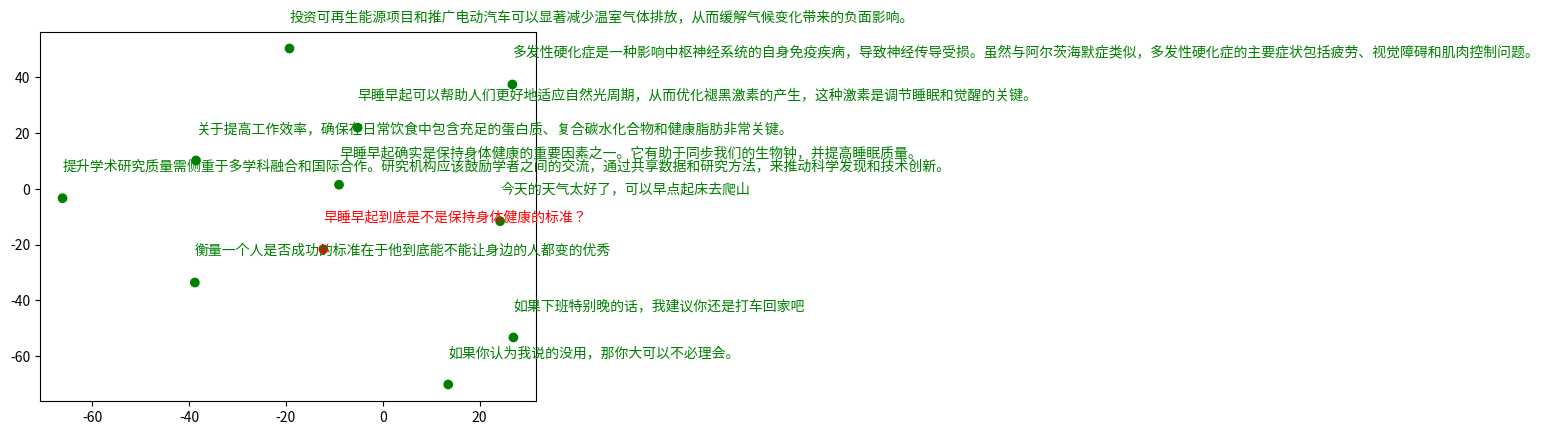

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 设置字体以支持中文显示
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 将查询句子的嵌入添加到句子嵌入数组的首位
all_embeddings = np.vstack([embedded_query, sentence_embeddings])

# 运行 TSNE 降维，固定随机种子以保持结果一致
# n_components (整数): 这个参数指定目标空间的维度。在这里设置为 2，意味着t-SNE将把数据降维到二维空间。
# perplexity (浮点数): 这个参数是t-SNE中非常重要的一个参数，可以看作是考虑周围邻居的数量，它反映了数据局部结构的复杂性。
tsne = TSNE(n_components=2, perplexity=5)  
embeddings_2d = tsne.fit_transform(all_embeddings)

# 创建颜色列表，查询句子为红色，其余为绿色
color_list = ['red'] + ['green'] * len(sentence_embeddings)

# 绘制散点图
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color_list)

# 添加文本标签，包括查询句子
sentences_with_query = [query] + sentences  # 加入查询句子到句子列表首位
for i in range(len(embeddings_2d)):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1] + 10,  # 小幅调整文本位置以防重叠
             sentences_with_query[i],
             color=color_list[i])

    
# 显示图表
plt.show()

&emsp;&emsp;从这个结果看，相较于OpenAI的Embedding Models生成的向量表示，还是有一些差距，至少从上述可视化图表中发现相似的文本并没有很好的分布在相邻的簇中。但其实这并不绝对，因为TSNE降维本身就是一个不稳定的过程，可能在原始的高维向量表示中并不会出现这样的问题。所以大家仅把上述可视化结果作为一个直观参考即可，在开源的Embedding 模型中，`bge-large-zh-v1.5`生成的词向量还是比较优秀的。当然，开源模型的性能相较于在线模型，尤其是跟OpenAI的模型相比，存在很大的差距这也是实际存在的。

&emsp;&emsp;那么如何根据自己的数据情况选择最合适的Embedding 模型呢，这里有一个基本的衡量方法。首先，在Huggging Face 的 mteb/leaderboard 有一个较为优质的评测榜单：https://huggingface.co/spaces/mteb/leaderboard

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404180951124.png" width=100%></div>

&emsp;&emsp;在选择Embedding模型时，大家可以考虑以下四个关键因素来确保能选取到最适合当前需求的模型：

1. **文本长度和块大小（Chunk Size 和 Sequence Length）**：模型选择应基于文本块的大小和序列长度，这通常取决于预期回答的长度。选择能够有效处理特定文本长度的模型。

2. **Embedding维度**：维度大小并非总是越大越好。如果文本语义丰富，较高的维度可能更有利于捕捉复杂信息。然而，对于语义较简单和直接的文本，较小的维度可能更为有效。

3. **模型大小和硬件资源**：根据可用的硬件资源（如显存大小），选择合适的模型。如果硬件资源充足，可以选择较大的模型，一般来说模型越大，性能越好，但是这并不绝对。

4. **实际测试和验证**：使用一个简单的Demo来测试模型的实际效果。如果初步的可视化测试结果不理想，那么有可能是不适合的。但这并不绝对，比如上面的例子，因为是降维之后的可视化，所以有可能在高维下，其表现是很好的，所以要综合衡量。

## 1.3 计算向量之间的相似度

&emsp;&emsp;在上面的例子中，我们用可视化降维来衡量不同文本之间的相似度是不精准且随机的，所以向量之间的相似度往往是通过一些具体的算法来计算的，向量和标量最大的区别在于向量是有方向的，而标量没有方向，只有大小。那么对于向量，一些常用的计算方法比如：

- 点积（内积）: 两个向量的点积是一种衡量它们在同一方向上投影的大小的方法。如果两个向量是单位向量（长度为1），它们的点积等于它们之间夹角的余弦值。因此，点积经常被用来计算两个向量的相似度。

- 余弦相似度: 这是一种通过测量两个向量之间的角度来确定它们相似度的方法。余弦相似度是两个向量点积和它们各自长度乘积的商。这个值的范围从-1到1，其中1表示完全相同的方向，-1表示完全相反，0表示正交。

- 欧氏距离: 这种方法测量的是两个向量在n维空间中的实际距离。虽然它通常用于计算不相似度（即距离越大，不相似度越高），但可以通过某些转换（如取反数或用最大距离归一化）将其用于相似度计算。

&emsp;&emsp;像我们最常用的余弦相似度，其代码实现也非常简单，如下所示：

In [93]:
import numpy as np

def cosine_similarity(A, B):
    # 使用numpy的dot函数计算两个数组的点积
    # 点积是向量A和向量B在相同维度上对应元素乘积的和
    dot_product = np.dot(A, B)
    
    # 计算向量A的欧几里得范数（长度）
    # linalg.norm默认计算2-范数，即向量的长度
    norm_A = np.linalg.norm(A)
    
    # 计算向量B的欧几里得范数（长度）
    norm_B = np.linalg.norm(B)
    
    # 计算余弦相似度
    # 余弦相似度定义为向量点积与向量范数乘积的比值
    # 这个比值表示了两个向量在n维空间中的夹角的余弦值
    return dot_product / (norm_A * norm_B)

&emsp;&emsp;接下来，定义一个`get_embedding`函数，使用OpenAI的Embedding Models来对文本生成向量。

In [94]:
from openai import OpenAI

client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [98]:
embedding1 = get_embedding("我正在学习大模型技术应用实战课")
embedding2 = get_embedding("如果你想找到大模型岗位的工作，一定要来学习大模型技术实战课")
embedding3 = get_embedding("我喜欢打篮球")

In [99]:
len(embedding1)

1536

&emsp;&emsp;然后用定义好的`cosine_similarity`函数，使用余弦相似度计算两个文本间的相似度。

In [101]:
cosine_similarity(embedding1, embedding2)

0.7666159961051081

In [102]:
cosine_similarity(embedding1, embedding3)

0.2592496452954112

In [103]:
embedding4 = get_embedding("我也在学习大模型技术应用实战课")

In [104]:
cosine_similarity(embedding1, embedding4)

0.9560139118248139

&emsp;&emsp;从上面这个测试结果能看出，当两段文本的语义越相近，通过余弦相似度计算出来的分数就越高。这也是衡量文本相似度最为常用的方法。当然，我们也可以把这个流程应用在LangChain的数据处理流中，如下：

&emsp;&emsp;首先，我们通过`Document Loaders`读取到一个外部的.txt文件。

In [105]:
from langchain.document_loaders import TextLoader

docs = TextLoader('./data/Multitheme_Test_Document_Chinese.txt', encoding="utf-8").load()

In [107]:
print(docs[0].page_content)


科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。

环境保护：
全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。

经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

文化艺术：
中国传统文化如书法和京剧在现代社会中依然占有重要地位。同时，现代艺术家也在尝试将传统艺术形式与现代技术结合，创造出新的艺术表现形式。艺术节和展览为这些创新提供了展示的平台。

健康生活：
现代生活节奏加快，健康问题也越来越受到人们的关注。健康饮食、规律运动是维持健康的重要因素。此外，心理健康和压力管理也开始被更多人重视，相关的研究和讨论日益增多。

旅游探险：
旅游已成为现代人生活的一部分，不仅是放松心情，更是一种文化和自我探索的方式。从遥远的北极圈到热带雨林，人们越来越愿意探索未知的领域，体验不同的文化和自然环境。



&emsp;&emsp;这份文档中的文本内容覆盖了多个主题，用来增强测试的复杂性。接下来，使用`Text Splitters`中的`RecursiveCharacterTextSplitter`进行文本分块：

In [108]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=0)

In [110]:
docs = text_splitter.split_documents(docs)

In [111]:
len(docs)

6

In [113]:
docs[0].page_content

'科技创新：\n随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。'

In [114]:
docs[1].page_content

'环境保护：\n全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。'

In [115]:
for index, doc in enumerate(docs):
    print(f"Chunk {index + 1}: {doc.page_content}\n")

Chunk 1: 科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。

Chunk 2: 环境保护：
全球气候变化对自然和人类社会构成了巨大的挑战。在这种情况下，推广绿色能源、减少塑料使用并保护生态多样性显得尤为重要。多国政府和非政府组织正在努力寻找解决方案，以减轻环境退化的影响。

Chunk 3: 经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

Chunk 4: 文化艺术：
中国传统文化如书法和京剧在现代社会中依然占有重要地位。同时，现代艺术家也在尝试将传统艺术形式与现代技术结合，创造出新的艺术表现形式。艺术节和展览为这些创新提供了展示的平台。

Chunk 5: 健康生活：
现代生活节奏加快，健康问题也越来越受到人们的关注。健康饮食、规律运动是维持健康的重要因素。此外，心理健康和压力管理也开始被更多人重视，相关的研究和讨论日益增多。

Chunk 6: 旅游探险：
旅游已成为现代人生活的一部分，不仅是放松心情，更是一种文化和自我探索的方式。从遥远的北极圈到热带雨林，人们越来越愿意探索未知的领域，体验不同的文化和自然环境。



&emsp;&emsp;如上所示，我们把每一个主题切分为一个单独的Chunk，一共生成了6个Chunk。接下来，通过OpenAI 的Embedding Models获取每个Chunk的向量表示：

In [116]:
from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [117]:
embeddings = [get_embedding(doc.page_content) for doc in docs]

In [118]:
embeddings

[[0.05330557003617287,
  0.0033988060895353556,
  0.02175620011985302,
  0.008372200652956963,
  0.06355959177017212,
  -0.021929020062088966,
  -0.01826138235628605,
  0.028265777975320816,
  0.025577455759048462,
  0.0069272276014089584,
  0.018078960478305817,
  -0.04550943896174431,
  -0.07101008296012878,
  0.019451923668384552,
  -0.011118128895759583,
  -0.022255459800362587,
  -0.06640153378248215,
  -0.01367203425616026,
  0.06524939835071564,
  -0.045586246997117996,
  -0.020469646900892258,
  0.020412039011716843,
  0.014017675071954727,
  -0.007700120098888874,
  0.004855780396610498,
  -0.0142577039077878,
  0.02071927674114704,
  0.003072367049753666,
  -0.027171246707439423,
  -0.01087810005992651,
  -0.00609672861173749,
  -0.007781730033457279,
  -0.00911628920584917,
  -0.011982232332229614,
  0.018270984292030334,
  0.012001434341073036,
  -0.013537617400288582,
  -0.05745326727628708,
  0.024578936398029327,
  -0.027171246707439423,
  0.02999398484826088,
  -0.01998

In [119]:
len(embeddings)

6

In [120]:
len(embeddings[0])

1536

&emsp;&emsp;然后，通过如下代码获取到query的向量表示：

In [121]:
from openai import OpenAI
client = OpenAI()

response = client.embeddings.create(
    input="现在科技创新方面有什么进展？",
    model="text-embedding-3-small"
)

query_embedding = response.data[0].embedding

In [122]:
query_embedding

[0.05222642049193382,
 -0.03402891382575035,
 0.010314072482287884,
 0.04196612536907196,
 0.05898058041930199,
 -0.023209352046251297,
 0.03409344330430031,
 0.020079638808965683,
 0.02852233685553074,
 -0.014024557545781136,
 0.005245765671133995,
 -0.03516894578933716,
 -0.0763176828622818,
 -0.013067360036075115,
 -0.04366541653871536,
 -0.02916763909161091,
 -0.07304815948009491,
 -0.045730382204055786,
 0.007200492080301046,
 0.006307824514806271,
 0.006329334806650877,
 -0.014809675514698029,
 0.03232961893081665,
 -0.000405666243750602,
 0.011335800401866436,
 -0.02510223723948002,
 -0.04779534786939621,
 0.02443542517721653,
 -0.027704954147338867,
 -0.0019345608307048678,
 0.022327439859509468,
 -0.033512670546770096,
 0.0023862721864134073,
 -0.010771161876618862,
 -0.005444733425974846,
 0.03211451694369316,
 0.01251885388046503,
 0.012357528321444988,
 0.028371766209602356,
 0.005307606887072325,
 0.010335583239793777,
 -0.00497957831248641,
 0.008388922549784184,
 -0.0148

&emsp;&emsp;在有了原始文档和query的向量表示后，我们通过余弦相似度去匹配哪一个Chunk中的内容，与输入的query是最相近的。

In [123]:
# 计算与查询最相近的文档块
similarities = [cosine_similarity(query_embedding, emb) for emb in embeddings]
max_index = np.argmax(similarities)  # 找到最高相似性的索引

# 打印最相似的文档块
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

The most similar chunk is Chunk 1 with similarity 0.5309897627999302:
科技创新：
随着技术的快速发展，人工智能和机器学习已经成为当下最热门的话题之一。从智能助手到自动驾驶汽车，AI的应用正在改变我们的生活方式。同时，关于数据隐私和机器伦理的讨论也日益增加，呼吁制定更明确的规范和法律。


&emsp;&emsp;从输出上看，当query为`现在科技创新方面有什么进展？`,涉及到原始文档科技创新这一主题时，检索出来的最匹配内容就是存储着科技创新内容的这一个chunk。同样，我们可以继续进行测试，此次提问的query涉及经济问题：

In [124]:
from openai import OpenAI
client = OpenAI()

response = client.embeddings.create(
    input="现在的经济趋势怎么样？",
    model="text-embedding-3-small"
)

query_embedding = response.data[0].embedding

In [125]:
# 计算与查询最相近的文档块
similarities = [cosine_similarity(query_embedding, emb) for emb in embeddings]
max_index = np.argmax(similarities)  # 找到最高相似性的索引

# 打印最相似的文档块
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

The most similar chunk is Chunk 3 with similarity 0.5187429752808131:
经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。


In [126]:
# 打印最相似的文档块以及其他所有文档块的相似度
print(f"The most similar chunk is Chunk {max_index + 1} with similarity {similarities[max_index]}:")
print(docs[max_index].page_content)

# 打印其他每一个的相似度
print("\nSimilarities of other chunks:")
for index, similarity in enumerate(similarities):
    if index != max_index:
        print(f"Chunk {index + 1} similarity: {similarity}")

The most similar chunk is Chunk 3 with similarity 0.5187429752808131:
经济趋势：
在全球化的大背景下，中国经济持续其增长势头，同时全球经济格局也在经历重大的转变。数字货币和区块链技术被视为金融领域的革命性创新，预计将对世界经济产生深远的影响。

Similarities of other chunks:
Chunk 1 similarity: 0.2711499198189397
Chunk 2 similarity: 0.25374800564848365
Chunk 4 similarity: 0.2181703088205948
Chunk 5 similarity: 0.30004271836275526
Chunk 6 similarity: 0.21603203815866717


&emsp;&emsp;对于经济问题，也能够很好的检索出原始文档中存储经济相关内容的chunk，这样的流程从本质上就是RAG检索的过程，只不过，一个应用级的RAG系统仅通过这样的简单设计肯定是不行的，首先，知识库存储的内容不可能这么少，chunks也不可能只有我们示例中的6个，那么当一个用户的query进入到这个RAG系统，query作为一个向量，要去偌大的知识库中（可能有几万、上千万个chunks）中找到与其最接近、内容最相关的问题，这就变成了一个搜索问题。

&emsp;&emsp;如果每个都去一一进行比较，这肯定是不现实的，它的时间复杂度会非常高，那有效的解决办法就是向量数据库，所以向量数据库，解决的核心问题是：如何以一种高效的搜索策略快速的返回检索结果。

&emsp;&emsp;接下来，我们就详细探讨一下向量数据库的应用方法和使用技巧。

# 2. 向量数据库介绍

&emsp;&emsp;向量数据库，其解决的就是一个问题：更高效的实现搜索（Search）过程。传统数据库是先存储数据表，然后用查询语句（SQL）进行数据搜索，本质还是基于文本的精确匹配，这种方法对于关键字的搜索非常合适，但对于语义的搜索就非常弱。那么把传统数据库的索引思想引用到向量数据库中，同样是做搜索，在向量数据库的应用场景中就变成了：给定一个查询向量，然后在众多向量中找到最为相似的一些向量返回。这就不再是精确匹配，而是具有一定的模糊性，这就是所谓的最近邻（Nearest Neighbors）问题，而能实现这一点的则称之为【最近邻（搜索）算法】。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181144131.png" width=100%></div>

&emsp;&emsp;一种最容易想到的方法是暴力搜索，也就是我们在`1.3 计算向量之间的相似度`最后部分实现的那种计算形式，依次比较所有向量和查询向量的相似度，挑选出相似度最高的几个。而比较两个向量相似度的具体方法有很多，比如通过余弦相似度去计算两个向量的夹角，夹角越小表明两个文件之间越相似，或者直接计算两个向量的欧氏距离，距离越近越相似。而我们也提到了，实际应用中的向量规模往往都不会很小，这种毫无技术含量的暴力搜索会产生极高的搜索时间，在时效上很难保证的，所以必须找出一些方法来优化搜索的过程，那一个大致的思路就是：如果我们可以做到先为查询向量划分一个大致的范围后，再进入搜索，那么哪怕在这个范围内进行暴力搜索，其效率也会有一个质的提升。在机器学习领域呢，K-Means等聚类算法就能够做到这一点，那通过某种聚类算法分簇后，检索时其向量数据库的存储状态就会变成这样：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181321996.png" width=100%></div>

&emsp;&emsp;通过某种聚类算法先进行一轮训练，把相似向量划分到一个个不同的簇中，在实际执行搜索的时候，只需要找到和聚类向量中心点最近的那个向量，然后在这个簇中的执行搜索过程即可。但也会出现一些问题，比如下面这种情况：红色的点是查询向量落到的位置，它距离蓝色簇质心的距离最近，所以按照规则，它会去蓝色的簇中搜索向量，但实际上，与它最相近的向量是在黄色的簇中的红色点。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181328672.png" width=100%></div>

&emsp;&emsp;这个时候我们就可以通过划分多个簇来尽可能的减少这种遗漏的情况，但需要说明的是，一旦提高搜索质量通常会降低处理速度，这两者之间往往存在难以调和的矛盾。在实际应用中，几乎所有的算法都是在这两个指标之间寻求平衡。因此，除了暴力搜索之外，任何算法得到的都是一些近似的结果。这类算法也被称为“近似最近邻”（Approximate Nearest Neighbors，简称ANN）。

&emsp;&emsp;那除了聚类这种形式以外，减少搜索范围的方法还有很多，比如非常流行的哈希算法。哈希算法简单理解就是任何数据经过哈希函数计算后，都会输出一个固定的哈希值，那就会存在一个问题：将无限可能的输入映射到有限的输出范围内，就一定会出现不同的输入数据产生相同的哈希值的这种情况，这种现象被称为“碰撞”。一个理想的哈希算法是尽可能的减少这种碰撞，但向量数据库的哈希函数设计却反其道而行，它会倾向于增大碰撞发生的可能性，因为当哈希值一样，那它就会认为这两个向量是相似的，然后把这些向量划分到一起，在哈希算法下就不叫簇了，而叫做桶：Bucket。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181402159.png" width=100%></div>

&emsp;&emsp;除了增加碰撞的概率外，在向量数据库中的哈希函数让越相似的向量，发生碰撞的概率越高，通过这样的策略就会使得相似向量被分到同一个Bucket中的概率越大。如此，在查询的时候，先通过哈希函数找到查询向量的哈希值，然后去对应的Bucket中查找，以此来减小搜索范围。我们把具有这种特性的哈希函数称之为：位置敏感哈希 Locality Sensitive Hashing。当然，还有一些能够减低内存开销的搜索算法，比如有损压缩的PQ算法，基于图搜索的HNSW等，我们在后续使用时如果遇到，再开展给大家做详细的介绍。

&emsp;&emsp;总的来说，不同的向量数据库，底层实现的只是这种不同的逻辑，但核心都会搭建类似这样的流程。而在应用层面上，其展现出来将文本转换成向量，然后将向量存储在数据库中，当用户输入问题时，将问题转换成向量，然后在数据库中搜索最相似的向量和上下文，最后将文本返回给用户。

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171246990.png" width=80%></div>

&emsp;&emsp;目前市面上充斥着非常多的向量数据库，从整体上可以分为开源和闭源，当然闭源意味着我们需要付费使用，而对于开源的向量数据库来说，可以下载免费使用。通过官方的数据来看，最常用的向量数据库如下：

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181437374.png" width=80%></div>

&emsp;&emsp;其中Pinecone为闭源的向量数据库，Chroma为LangChain官方主推的向量数据库，同时Faiss和Qdrant 也非常受人们欢迎，且这三款均为开源的向量数据库，而像Postgres、Neo4j和Redis等原本较为传统的数据库，为适应当前大模型技术的发展趋势也添加了向量功能。

&emsp;&emsp;本节内容，我们就以Chroma 为示例，尝试一下在LangChain中如何使用集成的向量数据库，Faiss与Chrom的使用方式基本保持一致，所以我们就不再重复的说明，大家可以根据官方文档，结合我们接下来对Chroma的实操自行尝试。而关于Qdrant，它涉及到本地化部署的一些流程，我们将会在接下来的项目中向大家更加详细的介绍。

# 3. Chroma的使用方法

&emsp;&emsp;Chroma 是一家构建开源项目（也称为 Chroma）的公司，其官网：https://www.trychroma.com/

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404181451605.png" width=80%></div>

&emsp;&emsp;它支持用于搜索、过滤等的丰富功能，并能与多种平台和工具（如LangChain, LlamaIndex, OpenAI等）集成。Chroma的核心API包括四个命令，分别用于创建集合、添加文档、更新和删除，以及执行查询。Chroma向量数据库官方原生支持Python和JavaScript，也有其他语言的社区版本支持。所以可以直接通过Python或JS操作，具体的操作文档可查阅其官方：https://docs.trychroma.com/

> Collection 是一组具有相似属性的文档集合，相当于关系型数据库中的表。在向量数据库中，数据存储为 Document，一组文档构成一个 Collection，一个 Database 中可以包含多个 Collection。

&emsp;&emsp;我们这里重点看一下在LangChain框架中Chroma的应用。首先还是看其构建的函数类，这里面定义了在LangChain框架下使用Chroma向量数据库的所有方法。https://api.python.langchain.com/en/latest/vectorstores/langchain_chroma.vectorstores.Chroma.html#langchain_chroma.vectorstores.Chroma

<div align=center><img src="https://snowball101.oss-cn-beijing.aliyuncs.com/img/202404171258615.png" width=80%></div>

&emsp;&emsp;在使用时，因为Chroma是作为第三方集成，所以需要安装依赖包，执行如下代码：

In [83]:
# ! pip install langchain-chroma

&emsp;&emsp;这里我们使用OpenAI的Embedding模型，可以使用如下方式显式的在当前开发环境下配置OpenAI API Key。

In [2]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key: ········


&emsp;&emsp;然后我们加载一个本地的.txt文档，里面的内容就是关于Sora的一些介绍。

In [3]:
from langchain.document_loaders import TextLoader

raw_documents = TextLoader('./data/sora.txt', encoding="utf-8").load()

In [4]:
raw_documents

[Document(page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。\n\n尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。\n\n相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Transformer架构的表征方式，从而将ScalingLaw从语言模型复制到了图像视频模型。此外，Sora在训练时还借助了DALL·E3生成的高质量文本描述，在推理时借助了GPT对用户输入进行扩展，可谓“站在巨人肩膀上”更进一步。\n\n三、Sora对AI应用和算力需求带来哪些影响?\n\n对于应用而言，Sora生成的视频已经达到了大部分消费级场景的使用要求，将为短视频创作等创意产业带来繁荣。随着模型升级，预计也将对电影、游戏等行业的制作效率带来大幅提升。尽管Sora的商业化时间表还未披露，但ChatGPT之后又一

&emsp;&emsp;接下来，通过文档切割器`RecursiveCharacterTextSplitter`,将上面完整的Docement对象切分为多个chunks。

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""], # 默认
    chunk_size=500, #块长度
    chunk_overlap=20, #重叠字符串长度
    add_start_index=True
)

In [7]:
documents = text_splitter.split_documents(raw_documents)

In [8]:
len(documents)

6

In [9]:
print(documents[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


In [10]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

&emsp;&emsp;注意：Chroma 开源，但是OpenAI EMbedding是需要科学上网环境的。所以我们在实例化Embedding模型实例的时候，需要确保当前的环境是可以连接外网的。

In [12]:
embeddings_model = OpenAIEmbeddings()

&emsp;&emsp;我们看如下源码：`from_documents` 函数是`Chroma`类定义一个方法，主要用于从一系列文档（documents）中创建一个向量存储（vectorstore）。这个函数的功能点涉及多个方面，具体参数如下：

```python
    def from_documents(
        cls: Type[Chroma], # 类型参数，指向 Chroma 类型，用于方法中创建向量存储的实例。
        documents: List[Document], # 文档列表，每个文档都包含一些可用于生成向量的内容。
        embedding: Optional[Embeddings] = None,  # 可选的Embedding函数，用于将文档内容转换成向量。如果未提供，则使用默认设置。
        ids: Optional[List[str]] = None,  # 可选的文档ID列表，用于标识每个文档。
        collection_name: str = _LANGCHAIN_DEFAULT_COLLECTION_NAME,  # 向量存储的名称，默认为 _LANGCHAIN_DEFAULT_COLLECTION_NAME。
        persist_directory: Optional[str] = None,    # 如果指定，向量存储将被持久化到此目录。如果未指定，数据将只在内存中临时存在。
        client_settings: Optional[chromadb.config.Settings] = None,   # 可选的 Chroma 客户端配置设置。
        client: Optional[chromadb.ClientAPI] = None,  # Add this line   # 可选的 chromadb.ClientAPI 实例，用于数据库交互。
        collection_metadata: Optional[Dict] = None,  # 可选的字典，包含有关集合的额外元数据。
        **kwargs: Any,
    ) -> Chroma:
        """Create a Chroma vectorstore from a list of documents.

        If a persist_directory is specified, the collection will be persisted there.
        Otherwise, the data will be ephemeral in-memory.

        Args:
            collection_name (str): Name of the collection to create.
            persist_directory (Optional[str]): Directory to persist the collection.
            ids (Optional[List[str]]): List of document IDs. Defaults to None.
            documents (List[Document]): List of documents to add to the vectorstore.
            embedding (Optional[Embeddings]): Embedding function. Defaults to None.
            client_settings (Optional[chromadb.config.Settings]): Chroma client settings
            collection_metadata (Optional[Dict]): Collection configurations.
                                                  Defaults to None.

        Returns:
            Chroma: Chroma vectorstore.
        """
        texts = [doc.page_content for doc in documents]
        metadatas = [doc.metadata for doc in documents]
        return cls.from_texts(
            texts=texts,
            embedding=embedding,
            metadatas=metadatas,
            ids=ids,
            collection_name=collection_name,
            persist_directory=persist_directory,
            client_settings=client_settings,
            client=client,
            collection_metadata=collection_metadata,
            **kwargs,
        )
```

&emsp;&emsp;这个方法的设计能够方便地从结构化文档数据中生成和管理向量存储，同时提供了灵活的配置选项（如Embedding Models的选择、持久化的选项等），以适应不同的应用场景和需求。

In [13]:
db = Chroma.from_documents(documents, embeddings_model)

In [14]:
query = "什么是Sora"
docs = db.similarity_search(query)
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


```python
 def similarity_search(
        self,
        query: str,
        k: int = DEFAULT_K,
        filter: Optional[Dict[str, str]] = None,
        **kwargs: Any,
    ) -> List[Document]:
        """Run similarity search with Chroma.

        Args:
            query (str): Query text to search for.
            k (int): Number of results to return. Defaults to 4.
            filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.

        Returns:
            List[Document]: List of documents most similar to the query text.
        """
        docs_and_scores = self.similarity_search_with_score(
            query, k, filter=filter, **kwargs
        )
        return [doc for doc, _ in docs_and_scores]
    
    
    
    def similarity_search_with_score(
            self,
            query: str,
            k: int = DEFAULT_K,
            filter: Optional[Dict[str, str]] = None,
            where_document: Optional[Dict[str, str]] = None,
            **kwargs: Any,
        ) -> List[Tuple[Document, float]]:
            """Run similarity search with Chroma with distance.

            Args:
                query (str): Query text to search for.
                k (int): Number of results to return. Defaults to 4.
                filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.

            Returns:
                List[Tuple[Document, float]]: List of documents most similar to
                the query text and cosine distance in float for each.
                Lower score represents more similarity.
            """
            if self._embedding_function is None:
                results = self.__query_collection(
                    query_texts=[query],
                    n_results=k,
                    where=filter,
                    where_document=where_document,
                    **kwargs,
                )
            else:
                query_embedding = self._embedding_function.embed_query(query)
                results = self.__query_collection(
                    query_embeddings=[query_embedding],
                    n_results=k,
                    where=filter,
                    where_document=where_document,
                    **kwargs,
                )

            return _results_to_docs_and_scores(results)
```

&emsp;&emsp;在这段代码中， `_embedding_function` 会将查询字符串（自然语言）转换成一个Vector向量，通过 `__query_collection` 处理具体的搜索逻辑，利用余弦相似度在数据库中查找最相似的k个文档向量，最后，通过 `_results_to_docs_and_scores` 函数，可以将搜索结果转换成具体的文档列表和它们与查询的相似度评分。这个评分通常反映了查询向量与文档向量之间的距离，距离越小表示相似度越高。

In [15]:
print(documents[3].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


In [16]:
query = "Sora在训练时消耗了多少算力？"
docs = db.similarity_search(query)
print(docs[0].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


&emsp;&emsp;除此之外，还可以使用`similarity_search_by_vector` 搜索与给定Emgbedding向量类似的文档，它接受Embedding向量作为参数而不是字符串。

```python
def similarity_search_by_vector(
        self,
        embedding: List[float],
        k: int = DEFAULT_K,
        filter: Optional[Dict[str, str]] = None,
        where_document: Optional[Dict[str, str]] = None,
        **kwargs: Any,
    ) -> List[Document]:
        """Return docs most similar to embedding vector.
        Args:
            embedding (List[float]): Embedding to look up documents similar to.
            k (int): Number of Documents to return. Defaults to 4.
            filter (Optional[Dict[str, str]]): Filter by metadata. Defaults to None.
        Returns:
            List of Documents most similar to the query vector.
        """
        results = self.__query_collection(
            query_embeddings=embedding,
            n_results=k,
            where=filter,
            where_document=where_document,
            **kwargs,
        )
        return _results_to_docs(results)
```

&emsp;&emsp;所以在使用时，就需要先将Query也转化成Vector。

In [18]:
query = "Sora在训练时消耗了多少算力？"

embedding_vector = OpenAIEmbeddings().embed_query(query)
docs = db.similarity_search_by_vector(embedding_vector)
print(docs[0].page_content)

对于算力而言，由于OpenAI并未公布模型架构的细节，很难推测训练Sora具体消耗了多少算力，但既然ScalingLaw，或者说“大力出奇迹”依然是当前AI模型实现“涌现”的黄金法则，就意味着对算力的需求仍然没有看到“拐点”。如果Sora的训练确实使用了合成数据，意味着可供训练的数据远未耗尽，人类对AI模型参数和训练数据的提升还远远没有达到瓶颈。甚至随着AI模型合成数据能力的增强，模型推理结果本身就可以作为训练的一部分，从而实现AI的自我迭代。此外，视频生成推理需要更大的VRAM或带宽，如果Sora开放使用后如期推动各类视频创作的繁荣，当前电信和数通网络的带宽都需要大幅升级。作为广义算力的一部分，网络设备的需求也将爆发式增长。

对于投资而言，Sora最大的意义在于证明了AI产业的创新浪潮还远未停歇。Sora的“前辈”ChatGPT发布以来，芯片龙头英伟达、博通股价分别上涨超300%、130%，软件应用龙头微软上涨超60%。Sora作为多模态大模型，向公众开放后预计对算力需求更大、对软件应用成长空间提升更显著，有望进一步提升相关产业投资价值。


&emsp;&emsp;如果切换到开源的Embeddings，其流程是一样的。这里我们可以使用`bge-large-zh-v1.5`再次进行测试。首先，我们重新读取文件并完成Chunks的切分。

In [1]:
from langchain_community.vectorstores import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


raw_documents = TextLoader('./data/sora.txt', encoding="utf-8").load()
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""], # 默认
    chunk_size=500, #块长度
    chunk_overlap=20, #重叠字符串长度
    add_start_index=True
)

documents = text_splitter.split_documents(raw_documents)

In [2]:
len(documents)

6

In [3]:
documents

[Document(page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。', metadata={'source': './data/sora.txt', 'start_index': 0}),
 Document(page_content='尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。', metadata={'source': './data/sora.txt', 'start_index': 253}),
 Document(page_content='相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Transformer架构的表征方式，从而将ScalingLaw从语言模型复制到了图像视频模型。此外，Sora在训练时还借助了DALL·E3生成的高质量文本描述，在推理时借助了GPT对用户输入

&emsp;&emsp;这里通过`HuggingFaceEmbeddings`类实例化`bge-large-zh-v1.5`模型。

In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings_model = HuggingFaceEmbeddings(model_name="/home/Work/00.Work_muyu/langchain/bge-large-zh-v1.5")
# Equivalent to SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

/home/util/anaconda3/envs/langchain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


&emsp;&emsp;同样调用`.from_documents`方法生成并存储向量表示。

In [5]:
db = Chroma.from_documents(documents, embeddings_model)

&emsp;&emsp;执行向量检索：

In [7]:
# 输入查询的问题
query = "Sora是什么？"
docs = db.similarity_search(query, k=1)

In [8]:
docs

[Document(page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。', metadata={'source': './data/sora.txt', 'start_index': 0})]

&emsp;&emsp;通过关键词k，可以设置返回多少个在查询过程中与Query最接近的Chunks。

In [10]:
# 输入查询的问题
query = "Sora是什么？"
docs = db.similarity_search(query, k=2)
docs

[Document(page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。', metadata={'source': './data/sora.txt', 'start_index': 0}),
 Document(page_content='相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Transformer架构的表征方式，从而将ScalingLaw从语言模型复制到了图像视频模型。此外，Sora在训练时还借助了DALL·E3生成的高质量文本描述，在推理时借助了GPT对用户输入进行扩展，可谓“站在巨人肩膀上”更进一步。\n\n三、Sora对AI应用和算力需求带来哪些影响?\n\n对于应用而言，Sora生成的视频已经达到了大部分消费级场景的使用要求，将为短视频创作等创意产业带来繁荣。随着模型升级，预计也将对电影、游戏等行业的制作效率带来大幅提升。尽管Sora的商业化时间表还未披露，但ChatGPT之后又一风靡全球的AI杀手级应用无疑已经提上了日程。此外，Sora的推出强化了产业界对于实现通用人工智能的信心，预计全球科技领域的巨头将持续向AI投入资源，加速产业发展进程。', metadata={'source': './data/sora.txt', 'start_index': 669})]

In [11]:
# 查看检索到的结果
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


&emsp;&emsp;在构建实际应用程序时，除了添加和检索，非常多的情况下还需要更新和删除数据，这就需要借助到Chroma类定义的` ids` 参数，它可以传入文件名或任意的标识。我们需要先根据分成Chunks构建起唯一的对应id。

In [5]:
# create simple ids
ids = [str(i) for i in range(1, len(documents) + 1)]
ids

['1', '2', '3', '4', '5', '6']

&emsp;&emsp;然后重新构造Chroma实例，并设置新的参数ids。

In [6]:
new_db = Chroma.from_documents(documents, embeddings_model,ids=ids)

&emsp;&emsp;然后进行检索：

In [9]:
# 输入查询的问题
query = "Sora是什么？"
docs = new_db.similarity_search(query, k=2)
docs

[Document(page_content='一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。', metadata={'source': './data/sora.txt', 'start_index': 0}),
 Document(page_content='相比GPT模型，Sora的成功之处在于为图像视频等多模态数据找到了适合Transformer架构的表征方式，从而将ScalingLaw从语言模型复制到了图像视频模型。此外，Sora在训练时还借助了DALL·E3生成的高质量文本描述，在推理时借助了GPT对用户输入进行扩展，可谓“站在巨人肩膀上”更进一步。\n\n三、Sora对AI应用和算力需求带来哪些影响?\n\n对于应用而言，Sora生成的视频已经达到了大部分消费级场景的使用要求，将为短视频创作等创意产业带来繁荣。随着模型升级，预计也将对电影、游戏等行业的制作效率带来大幅提升。尽管Sora的商业化时间表还未披露，但ChatGPT之后又一风靡全球的AI杀手级应用无疑已经提上了日程。此外，Sora的推出强化了产业界对于实现通用人工智能的信心，预计全球科技领域的巨头将持续向AI投入资源，加速产业发展进程。', metadata={'source': './data/sora.txt', 'start_index': 669})]

In [11]:
# 查看检索到的结果
print(docs[0].page_content)

一、Sora是什么？为什么说Sora是人工智能划时代的突破?

2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。


In [12]:
# 查看检索到的结果
print(docs[0].metadata)

{'source': './data/sora.txt', 'start_index': 0}


&emsp;&emsp;然后，我们可以直接修改metadata，如下所示：

In [13]:
# update the metadata for a document
docs[0].metadata = {
    "source": "./data/sora.txt",
    "new_value": "这是我主动更新的",
}

&emsp;&emsp;接着，执行`update_document`方法进行更新，如下所示：

In [15]:
new_db.update_document(ids[0], docs[0])

&emsp;&emsp;如下源码所示： `update_documents`方法用于更新向量库中的一组文档，具体来看：它从传入的文档列表中，提取出所有文档的页面内容（page_content）和元数据（metadata），然后执行更新过程。

```python
def update_documents(self, ids: List[str], documents: List[Document]) -> None:  # type: ignore
        """Update a document in the collection.

        Args:
            ids (List[str]): List of ids of the document to update.
            documents (List[Document]): List of documents to update.
        """
        text = [document.page_content for document in documents]
        metadata = [document.metadata for document in documents]
        if self._embedding_function is None:
            raise ValueError(
                "For update, you must specify an embedding function on creation."
            )
        embeddings = self._embedding_function.embed_documents(text)

        if hasattr(
            self._collection._client, "max_batch_size"
        ):  # for Chroma 0.4.10 and above
            from chromadb.utils.batch_utils import create_batches

            for batch in create_batches(
                api=self._collection._client,
                ids=ids,
                metadatas=metadata,  # type: ignore
                documents=text,
                embeddings=embeddings,  # type: ignore
            ):
                self._collection.update(
                    ids=batch[0],
                    embeddings=batch[1],
                    documents=batch[3],
                    metadatas=batch[2],
                )
        else:
            self._collection.update(
                ids=ids,
                embeddings=embeddings,  # type: ignore
                documents=text,
                metadatas=metadata,  # type: ignore
            )
```

&emsp;&emsp;与任何其他数据库一样，在向量数据库中，也可以使用`.add`、`.get` 、`.update` `.delete`等方法，但如果想直接访问，需要执行`._collection.method()`。所以我们可以通过如下的代码形式，查看更新后的内容：

In [17]:
print(new_db._collection.get(ids=[ids[0]]))

{'ids': ['1'], 'embeddings': None, 'metadatas': [{'new_value': '这是我主动更新的', 'source': './data/sora.txt', 'start_index': 0}], 'documents': ['一、Sora是什么？为什么说Sora是人工智能划时代的突破?\n\n2024年2月16日凌晨，OpenAI在官网发布了最新的文生视频模型Sora。Sora不仅突破了现有文生视频模型10秒左右的连贯性局限，而且展示出了更精细的画质、多角度多镜头切换中保持一致性等能力。最重要的是，Sora较好地表现出了现实世界中的逻辑，比如在模型生成的两艘海盗船在咖啡杯内航行的视频中，咖啡的流动完全符合现实世界中的流体力学；比如一则宠物猫等待主人起床的视频中，宠物猫踩奶的动作、对主人鼻头的轻触都符合现实世界中动物的习性。'], 'uris': None, 'data': None}


&emsp;&emsp;对于第二个chunks也是一样的。

In [18]:
# 查看检索到的结果
print(docs[1].metadata)

{'source': './data/sora.txt', 'start_index': 669}


In [19]:
print(new_db._collection.get(ids=[ids[1]]))

{'ids': ['2'], 'embeddings': None, 'metadatas': [{'source': './data/sora.txt', 'start_index': 253}], 'documents': ['尽管出于安全性和测试验证等原因，Sora尚未开放给公众使用，但通过观察OpenAI发布的demo，不难发现Sora已经初步具备了理解现实世界运行规律的能力，即“涌现”的能力被成功得从大语言模型复制到了文生视频模型中。假以时日，人类或将很难区分现实世界和由AI生成的虚拟世界。除了为视频制作、电影剪辑、游戏设计等工作提升效率外，一个完全由数据驱动的数字世界或许已经近在咫尺。英伟达人工智能研究院首席科学家JimFan称“这是视频生成领域的GPT-3时刻”。360董事长周鸿祎称“Sora意味着AGI（通用人工智能）实现将从10年缩短到1年”。\n\n二、Sora是如何实现的？\n\n尽管OpenAI在Sora的技术文档中并未公开所有模型细节，但我们可以通过其描述大致推测出，Sora的实现仍然依赖于OpenAI在大语言模型领域取得巨大成功的“大力出奇迹”思想，即通过大幅提升训练数据和参数规模实现视频精度和对现实世界物理关系的“涌现”。'], 'uris': None, 'data': None}


&emsp;&emsp;这里除了更新元数据，也可以通过字符的形式，更新Chunks存储的内容，如下所示：

In [20]:
# update the metadata for a document
docs[1].page_content = "这是我手动更新的文本"
# update the metadata for a document
docs[1].metadata = {
    "source": "./data/sora.txt",
    "data": "20240418",
}

In [21]:
new_db.update_document(ids[1], docs[1])

In [22]:
print(new_db._collection.get(ids=[ids[1]]))

{'ids': ['2'], 'embeddings': None, 'metadatas': [{'data': '20240418', 'source': './data/sora.txt', 'start_index': 253}], 'documents': ['这是我手动更新的文本'], 'uris': None, 'data': None}


&emsp;&emsp;当然，也可以直接进行删除操作，在删除之前，先看一下有多少个Chunks，代码如下所示：

In [23]:
print(new_db._collection.count())

6


&emsp;&emsp;删除最后一个chunk。

In [25]:
new_db._collection.delete(ids=[ids[-1]])

&emsp;&emsp;再次查看存储的总Chunks数。

In [26]:
print(new_db._collection.count())

5


&emsp;&emsp;可以看到，已经成功的把最后一个chunk删除，总存储的Chunks也有6个减为5个。

&emsp;&emsp;至此，我们就介绍了在LangChain中向量数据库的一个基本使用方法，它和Embedding Models在使用过程中都是上手容易，但想玩的转，总归还是需要一些更进阶的学习，不同的向量数据库，其操作方法和使用技巧也会有些许的差别，但其底层原理都是一致的，核心就是为了完成更搞笑的搜索任务。同时，在应用选型时，也要结合实际业务需求选择合适的向量数据库使用，评测榜单靠前的并不意味着一定适用于任何需求场景，是追求性能，还是需要降低成本，这是一个需要去权衡的问题，同时各个数据库内置实现的搜索算法是否适用存储的文本数据，向量数据库选型取决于多方面因素，往往需要经历一个周期性的调研工作后才能确定。但如果仅作为学习使用，则更适合选择轻量、易于上手的向量数据库进行实践。